# Rhythm detection based on partitioning song into equal parts
We will consider peaks in novelty function and try to find peaks such that their distance from the closest preceding beat is approximately the same as for other peaks throughout the song. We will assign one score point for each different distance rounded to the nearest millisecond.

Scoring will not be calculated for the whole song at once. It will be calculated on smaller chunks of the song. In this approach, we will simply divide the song into smaller parts of predefined length.

In [13]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from RhythmRecognition.onset import spectral
from RhythmRecognition.tempo import fourier
from RhythmRecognition.beat import score
from RhythmRecognition.rhythm import parts
from RhythmRecognition.beat.click_track import *
from RhythmRecognition.constants import *
import IPython.display as ipd

mpl.rcParams.update({'font.size': 16})

audiofile = "../audio_files/spark.wav"


## Compute novelty function
First step is to compute a novelty function of the audio signal.

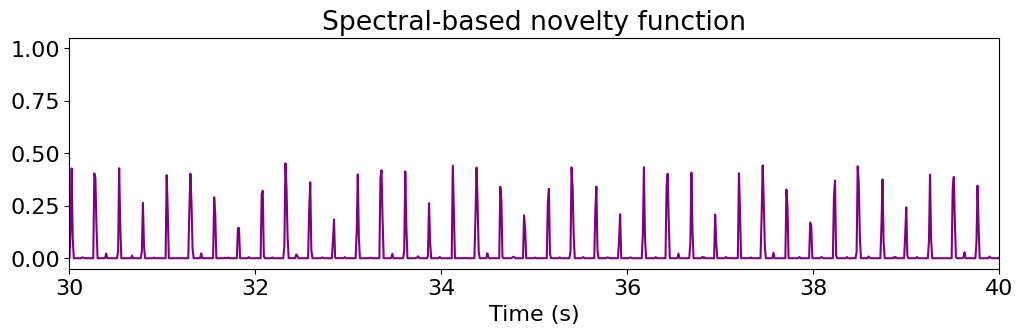

In [14]:
novelty_function = spectral.SpectralNovelty(audiofile)
novelty_function = novelty_function.get()

frames = np.arange(len(novelty_function))
t = librosa.frames_to_time(frames, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

plt.figure(figsize=(12, 3))
plt.plot(t, novelty_function, 'purple')
plt.xlim(30, 40)
plt.xlabel("Time (s)")
plt.title("Spectral-based novelty function")
plt.show()

## Compute tempogram
Then, we need to compute a tempogram of the song. We will use the Fourier-based tempogram, since it gives the best results.

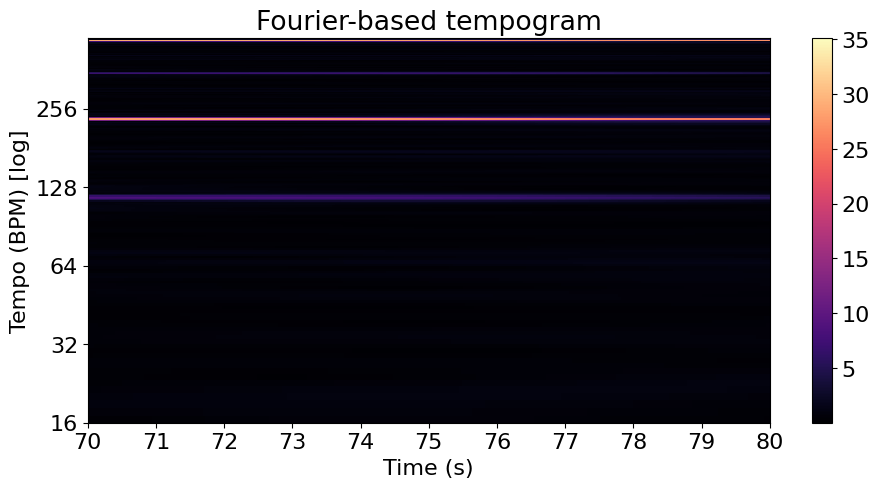

In [15]:
fourier_tempogram = fourier.FourierTempogram(novelty_function)
tempogram = fourier_tempogram.get_tempogram()

plt.figure(figsize=(11, 5))
librosa.display.specshow(tempogram, x_axis='time', y_axis='fourier_tempo', sr=SAMPLING_RATE, cmap='magma')
plt.xlabel("Time (s)")
plt.ylabel("Tempo (BPM) [log]")
plt.xlim(70, 80)
plt.colorbar()
plt.title("Fourier-based tempogram")
plt.show()

Then, we can extract the most dominant tempo from the tempogram (correct value is 117 BPM).

In [16]:
tempo = fourier_tempogram.get_tempo()
print(tempo)

117


## Beat detection
After computing the tempogram and obtaining the most dominant tempo, we can move to beat detection. 

### Beat time shift
We can compute the beat time shift. Correct time shift is 0 seconds, but small errors (difference around ~10 ms) are not detectable by human ears, so results with small errors are still classified as correct.

In [22]:
beat_tracker = score.ScoreBeatTracker(novelty_function, tempo=tempo)
shift = beat_tracker.get_time_shift()
print("Time shift:", shift, "seconds.")

Time shift: 0.012 seconds.


### Generate beat track over audio
We can generate a beat track over our song and listen to it to check if the found time shift is correct.

In [23]:
beat_track = beat_tracker.get_beat_track()  # get beat track

# load part of the audio signal
# unfortunately, ipd.Audio cannot generate the whole song with beat track over it, so we need to load a shorter part
signal, sr = librosa.load(audiofile, duration=30, sr=SAMPLING_RATE)

# create click track from beat times
click_track = librosa.clicks(times=beat_track, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)
ipd.Audio(signal + click_track, rate=SAMPLING_RATE)

### Plot beat times over novelty function
We can also create a plot with beat times drawn over the novelty function.

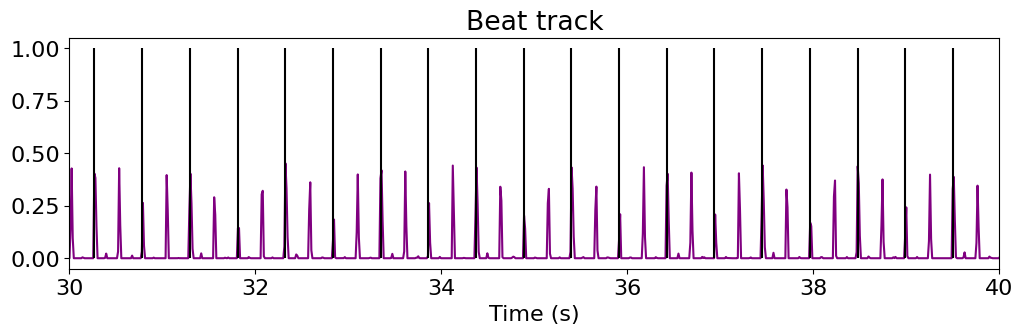

In [24]:
plt.figure(figsize=(12, 3))
plt.plot(t, novelty_function, 'purple')
plt.vlines(beat_track, 0, novelty_function.max(), color='black')
plt.xlim(30, 40)
plt.xlabel("Time (s)")
plt.title("Beat track")
plt.show()

## Rhythm detection
After beat detection, we can move to rhythm detection. 

### Generate rhythm track over audio
Just like with beat track, we can generate a rhythm track over the original song to determine how well rhythm detection worked.

*Note: the algorithm may return random clicks at the beginning of a song, before the song actually starts, since it might find some random peaks there and mistake them as note onsets.*

In [20]:
rhythm_tracker = parts.EqualPartsRhythmTracker(novelty_function=novelty_function, tempo=tempo, beat_times=beat_track)
rhythm_track = rhythm_tracker.find_rhythmic_onsets()

# create click track from beat times
click_track = librosa.clicks(times=rhythm_track, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)
ipd.Audio(signal + click_track, rate=SAMPLING_RATE)

### Plot rhythm track over beat track and novelty function
We can also check how well rhythm detection worked by plotting the rhythm track over the beat track. Some of the rhythmic note onsets should overlap with the beat track.

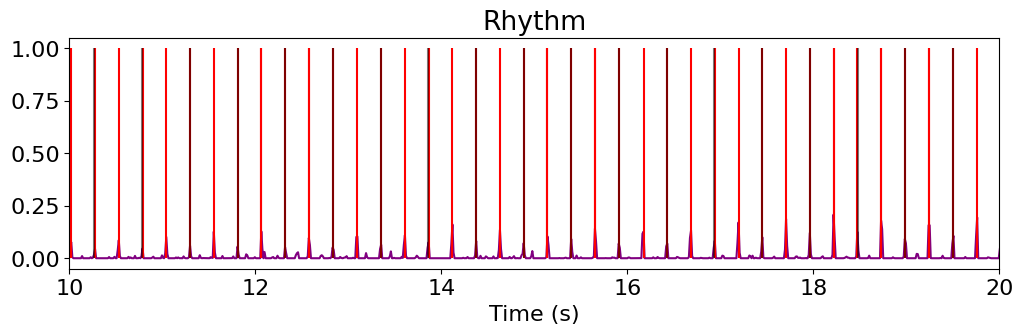

In [21]:
plt.figure(figsize=(12, 3))
plt.plot(t, novelty_function, 'purple')
plt.vlines(rhythm_track, 0, novelty_function.max(), color='red')
plt.vlines(beat_track, 0, novelty_function.max(), color='black', alpha=0.5)
plt.xlim(10, 20)
plt.xlabel("Time (s)")
plt.title("Rhythm")
plt.show()